In [19]:
import torchvision.models as models
import torch
import json
import torch.nn.functional as F

In [2]:
network = models.resnet50(pretrained=True)


In [3]:
from PIL import Image
from torchvision import transforms
input_image = Image.open("samoyed.jpg")
centre_crop = transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = centre_crop(input_image)
input_batch = input_tensor.unsqueeze(0) 

/usr/lib/python3.8/site-packages/torchvision/transforms/transforms.py:279: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


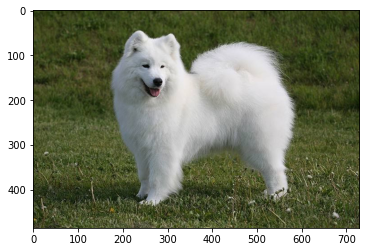

In [56]:
import matplotlib.pyplot as plt 
plt.imshow(input_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


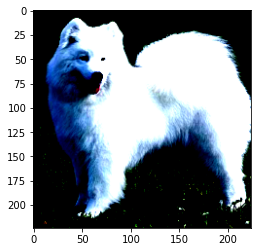

In [69]:
plt.imshow(input_batch[0].permute(1, 2, 0).detach().numpy())

In [5]:
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    network.to('cuda')


/usr/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [6]:
with torch.no_grad():
    network.eval()
    prediction = network(input_batch)  

In [7]:
with open('imagenet1000_clsid_to_human.json') as json_file:
    class_idx = json.load(json_file)
    labels = {int(key): value for key, value in class_idx.items()}


# Returns a Tensor of shape (batch, num class labels)
prediction = prediction.data.numpy().argmax()  # Our prediction will be the index of the class label with the largest value.
print(labels[prediction])

Samoyed, Samoyede


In [71]:
def fast_gradient_attack(image, correct_prediction_index, epsilon, network_to_attack):
    network.eval()
    image.requires_grad = True
    prediction = network_to_attack(image)
    prediction_index = prediction.max(1, keepdim=True)[1]
    print(prediction_index)
    print(prediction_index.shape)

    loss = F.nll_loss(prediction, correct_prediction_index)

    network.zero_grad()
    loss.backward()

    data_grad = image.grad.data


    changed_image = image + epsilon * data_grad.sign()

    changed_image = torch.clamp(changed_image, 0, 1)
    plt.imshow(  changed_image[0].permute(1, 2, 0).detach().numpy()  )
    new_prediction = network_to_attack(changed_image)
    print(labels[new_prediction.data.numpy().argmax()])

tensor([[258]])
torch.Size([1, 1])
Sealyham terrier, Sealyham


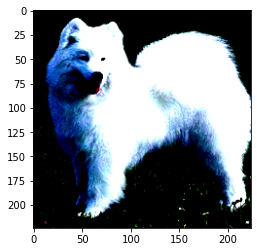

In [72]:
fast_gradient_attack(input_batch, torch.tensor([258]), 0.05, network)